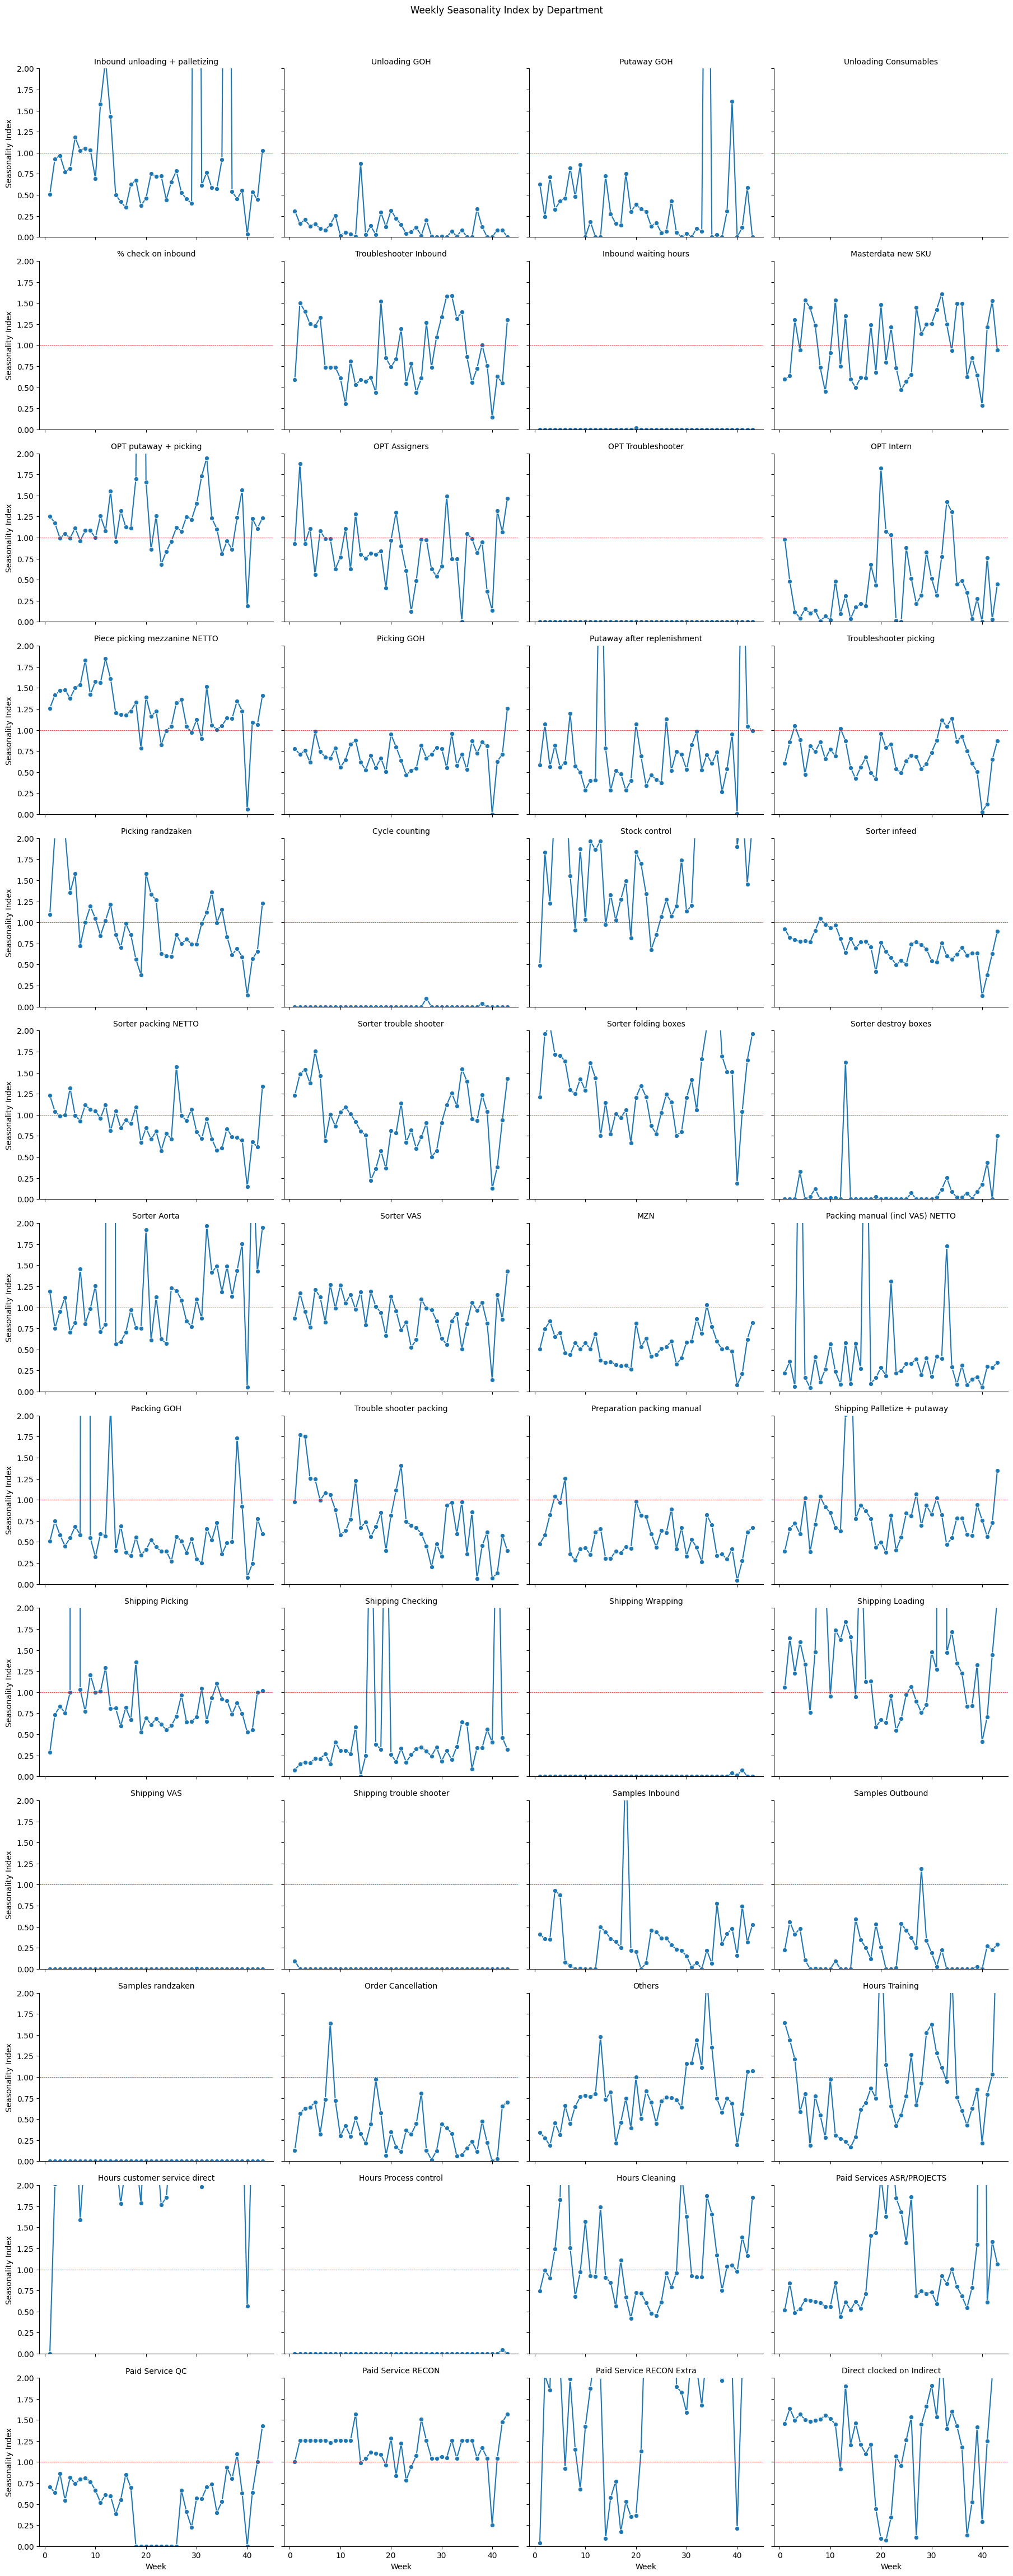

Output saved to seasonal_index_output.xlsx


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load Excel sheets and preprocess data
file_path = 'seasonal.xlsx'
actuals_df = pd.read_excel(file_path, sheet_name='Actual_2024')
baseline_df = pd.read_excel(file_path, sheet_name='Base_2024')

# Drop columns in actuals_df where all values are 0 or None
actuals_df = actuals_df.loc[:, ~(actuals_df.isnull().all() | (actuals_df == 0).all())]

# Set the index to 'Department' and convert date columns to datetime
actuals_df.set_index('Department', inplace=True)
actuals_df.columns = pd.to_datetime(actuals_df.columns, errors='coerce')

# Transpose and resample weekly for actuals
actuals_df = actuals_df.T
weekly_actuals = actuals_df.resample('W').sum()

# Prepare baseline values DataFrame aligned with actuals
baseline_values_df = baseline_df.set_index('Department')
baseline_daily = pd.DataFrame(index=actuals_df.index)

# DataFrame with repeated baseline values for each department
for department in baseline_values_df.index:
    baseline_daily[department] = [baseline_values_df.loc[department, 'Base']] * len(baseline_daily)

# Baseline using the count of actual days in each week
weekly_baseline = pd.DataFrame(index=weekly_actuals.index)
for week_start in weekly_baseline.index:
    week_end = week_start + pd.DateOffset(weeks=1)
    actual_days_count = actuals_df[week_start:week_end].count()
    for department in baseline_values_df.index:
        baseline_daily_value = baseline_values_df.loc[department, 'Base']
        weekly_baseline.loc[week_start, department] = baseline_daily_value * actual_days_count[department]

# Calculate seasonal index
seasonal_index_df = weekly_actuals.divide(weekly_baseline, axis=1)

# DataFrame for melting
output_df = pd.DataFrame()
for week_number in range(len(weekly_actuals)):
    if week_number < len(weekly_baseline) and week_number < len(seasonal_index_df):
        week_actuals = weekly_actuals.iloc[week_number].rename(f'week_{week_number + 1}_actuals')
        week_baseline = weekly_baseline.iloc[week_number].rename(f'week_{week_number + 1}_base')
        week_seasonal_index = seasonal_index_df.iloc[week_number].rename(f'week_{week_number + 1}_seasonal_index')
        output_df = pd.concat([output_df, week_actuals, week_baseline, week_seasonal_index], axis=1)

# Set the index to 'Department'
output_df.index = baseline_values_df.index

# Melt output_df to long format
output_long_df = output_df.reset_index().melt(id_vars='Department', var_name='week', value_name='value')

# Extract week number and metric from melted DataFrame
output_long_df['week_number'] = output_long_df['week'].str.extract(r'(\d+)').astype(int)
output_long_df['metric'] = output_long_df['week'].str.extract(r'_(actuals|base|seasonal_index)$')[0]

# Filter only for seasonal_index
seasonal_index_df = output_long_df[output_long_df['metric'] == 'seasonal_index']

# Plot seasonal index using FacetGrid to show weekly variations per department
g = sns.FacetGrid(seasonal_index_df, col='Department', col_wrap=4, height=3.5, aspect=1.3, sharey=True)
g.map_dataframe(sns.lineplot, x='week_number', y='value', marker='o')

# Set y-axis limits to 0-2 and add a horizontal line at y=1
for ax in g.axes.flat:
    ax.set_ylim(0, 2)
    ax.axhline(y=1, color='red', linestyle='--', linewidth=0.5)

# Set titles and labels
g.set_titles('{col_name}')
g.set_axis_labels('Week', 'Seasonality Index')
g.fig.suptitle('Weekly Seasonality Index by Department', y=1.01)

plt.tight_layout()
plt.show()

# Save the output DataFrame to an Excel file
output_file_path = 'seasonal_index_output.xlsx'
output_df.to_excel(output_file_path)
print(f"Output saved to {output_file_path}")


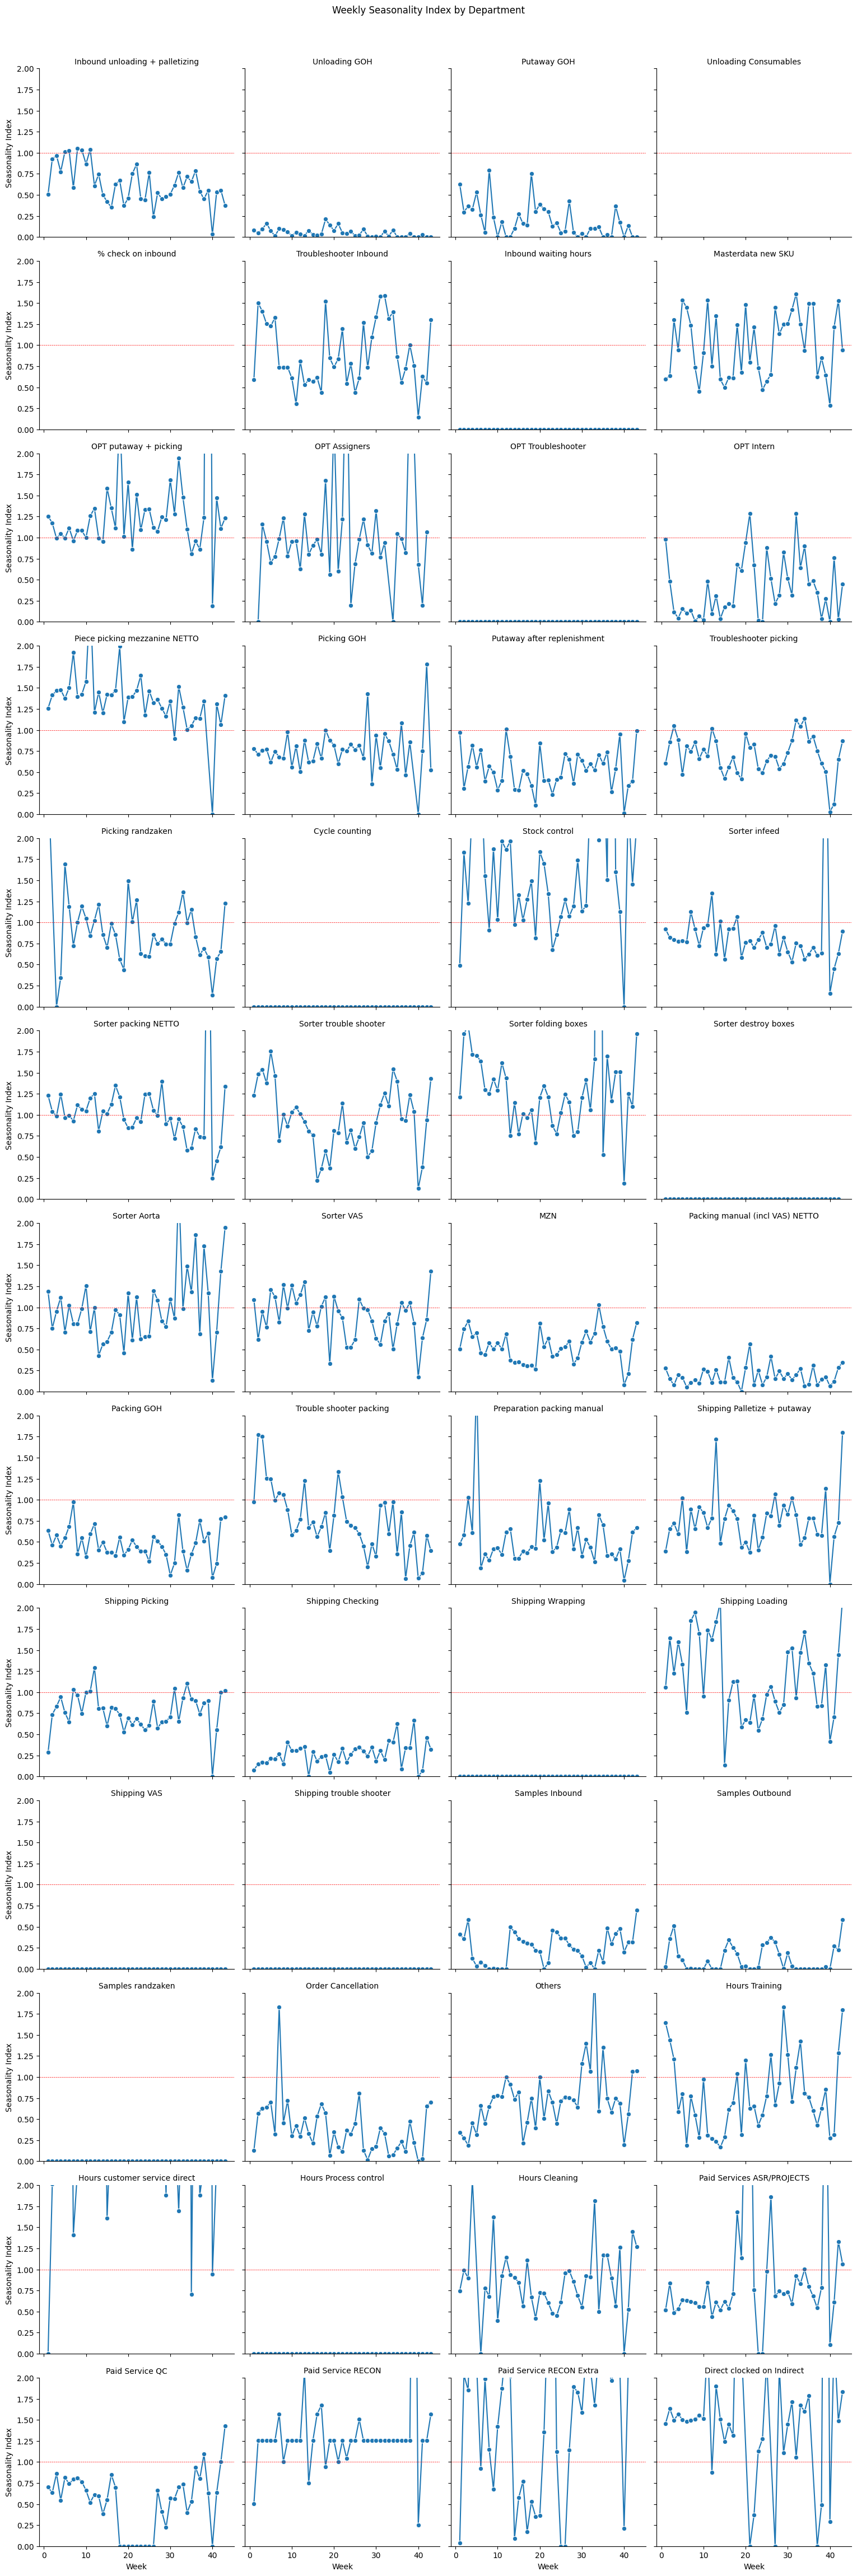

Output saved to seasonal_index_output_no_outliers_weekly_rolling_average.xlsx


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load Excel sheets and preprocess data
file_path = 'seasonal.xlsx'
actuals_df = pd.read_excel(file_path, sheet_name='Actual_2024')
baseline_df = pd.read_excel(file_path, sheet_name='Base_2024')

# Drop columns in actuals_df where all values are 0 or None
actuals_df = actuals_df.loc[:, ~(actuals_df.isnull().all() | (actuals_df == 0).all())]

# Set the index to 'Department' and convert date columns to datetime
actuals_df.set_index('Department', inplace=True)
actuals_df.columns = pd.to_datetime(actuals_df.columns, errors='coerce')

# Remove outliers in actuals_df
def remove_outliers(df):
    # Transpose to iterate over columns (i.e., departments)
    df = df.T
    cleaned_df = pd.DataFrame()
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        # Filter out outliers
        filtered_col = df[col].where((df[col] >= lower_bound) & (df[col] <= upper_bound))
        cleaned_df[col] = filtered_col
    return cleaned_df.T

# Apply outlier removal
actuals_df = remove_outliers(actuals_df)

# Transpose and resample weekly for actuals
actuals_df = actuals_df.T
weekly_actuals = actuals_df.resample('W').sum()

# Prepare baseline values DataFrame aligned with actuals
baseline_values_df = baseline_df.set_index('Department')
baseline_daily = pd.DataFrame(index=actuals_df.index)

# DataFrame with repeated baseline values for each department
for department in baseline_values_df.index:
    baseline_daily[department] = [baseline_values_df.loc[department, 'Base']] * len(baseline_daily)

# Baseline using the count of actual days in each week
weekly_baseline = pd.DataFrame(index=weekly_actuals.index)
for week_start in weekly_baseline.index:
    week_end = week_start + pd.DateOffset(weeks=1)
    actual_days_count = actuals_df[week_start:week_end].count()
    for department in baseline_values_df.index:
        baseline_daily_value = baseline_values_df.loc[department, 'Base']
        weekly_baseline.loc[week_start, department] = baseline_daily_value * actual_days_count[department]

# Calculate seasonal index
seasonal_index_df = weekly_actuals.divide(weekly_baseline, axis=1)

# DataFrame for melting
output_df = pd.DataFrame()
for week_number in range(len(weekly_actuals)):
    if week_number < len(weekly_baseline) and week_number < len(seasonal_index_df):
        week_actuals = weekly_actuals.iloc[week_number].rename(f'week_{week_number + 1}_actuals')
        week_baseline = weekly_baseline.iloc[week_number].rename(f'week_{week_number + 1}_base')
        week_seasonal_index = seasonal_index_df.iloc[week_number].rename(f'week_{week_number + 1}_seasonal_index')
        output_df = pd.concat([output_df, week_actuals, week_baseline, week_seasonal_index], axis=1)

# Set the index to 'Department'
output_df.index = baseline_values_df.index

# Melt output_df to long format
output_long_df = output_df.reset_index().melt(id_vars='Department', var_name='week', value_name='value')

# Extract week number and metric from melted DataFrame
output_long_df['week_number'] = output_long_df['week'].str.extract(r'(\d+)').astype(int)
output_long_df['metric'] = output_long_df['week'].str.extract(r'_(actuals|base|seasonal_index)$')[0]

# Filter only for seasonal_index
seasonal_index_df = output_long_df[output_long_df['metric'] == 'seasonal_index']

# Plot seasonal index using FacetGrid to show weekly variations per department
g = sns.FacetGrid(seasonal_index_df, col='Department', col_wrap=4, height=3.5, aspect=1.1, sharey=True)
g.map_dataframe(sns.lineplot, x='week_number', y='value', marker='o')

# Set y-axis limits to 0-2 and add a horizontal line at y=1
for ax in g.axes.flat:
    ax.set_ylim(0, 2)
    ax.axhline(y=1, color='red', linestyle='--', linewidth=0.5)

# Set titles and labels
g.set_titles('{col_name}')
g.set_axis_labels('Week', 'Seasonality Index')
g.fig.suptitle('Weekly Seasonality Index by Department', y=1.01)

plt.tight_layout()
plt.show()

# Save the output DataFrame to an Excel file
output_file_path = 'seasonal_index_output_no_outliers_weekly_rolling_average.xlsx'
output_df.to_excel(output_file_path)
print(f"Output saved to {output_file_path}")


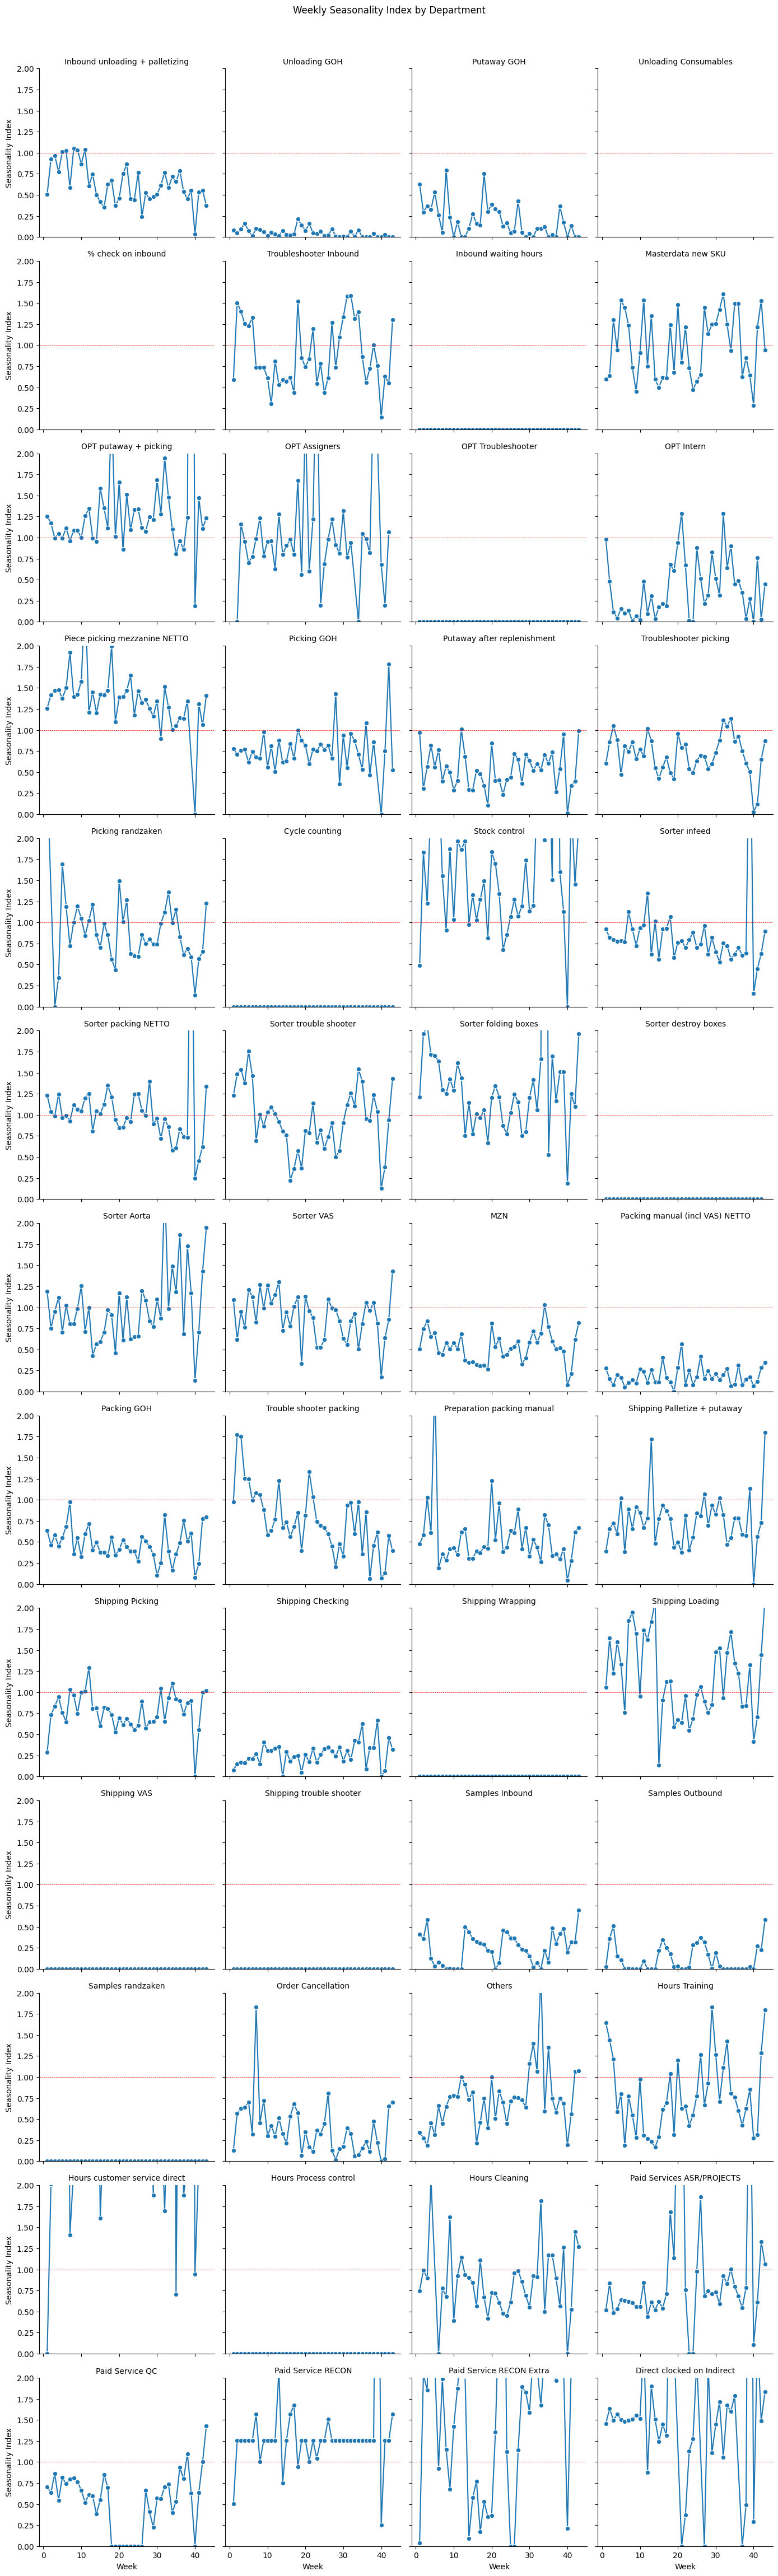

Output saved to seasonal_index_output_no_outliers_weekly_rolling_average.xlsx


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load Excel sheets and preprocess data
file_path = 'seasonal.xlsx'
actuals_df = pd.read_excel(file_path, sheet_name='Actual_2024')
baseline_df = pd.read_excel(file_path, sheet_name='Base_2024')

# Drop columns in actuals_df where all values are 0 or None
actuals_df = actuals_df.loc[:, ~(actuals_df.isnull().all() | (actuals_df == 0).all())]

# Set the index to 'Department' and convert date columns to datetime
actuals_df.set_index('Department', inplace=True)
actuals_df.columns = pd.to_datetime(actuals_df.columns, errors='coerce')

# Remove outliers in actuals_df
def remove_outliers(df):
    df = df.T
    cleaned_df = pd.DataFrame()
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        filtered_col = df[col].where((df[col] >= lower_bound) & (df[col] <= upper_bound))
        cleaned_df[col] = filtered_col
    return cleaned_df.T

# Apply outlier removal
actuals_df = remove_outliers(actuals_df)

# Transpose and resample weekly for actuals
actuals_df = actuals_df.T
weekly_actuals = actuals_df.resample('W').sum()

# Add rolling weekly average
rolling_weekly_avg = actuals_df.rolling(window=7, min_periods=1).mean()

# Prepare baseline values DataFrame aligned with actuals
baseline_values_df = baseline_df.set_index('Department')
baseline_daily = pd.DataFrame(index=actuals_df.index)

# DataFrame with repeated baseline values for each department
for department in baseline_values_df.index:
    baseline_daily[department] = [baseline_values_df.loc[department, 'Base']] * len(baseline_daily)

# Baseline using the count of actual days in each week
weekly_baseline = pd.DataFrame(index=weekly_actuals.index)
for week_start in weekly_baseline.index:
    week_end = week_start + pd.DateOffset(weeks=1)
    actual_days_count = actuals_df[week_start:week_end].count()
    for department in baseline_values_df.index:
        baseline_daily_value = baseline_values_df.loc[department, 'Base']
        weekly_baseline.loc[week_start, department] = baseline_daily_value * actual_days_count[department]

# Calculate seasonal index
seasonal_index_df = weekly_actuals.divide(weekly_baseline, axis=1)

# DataFrame for melting
output_df = pd.DataFrame()
for week_number in range(len(weekly_actuals)):
    if week_number < len(weekly_baseline) and week_number < len(seasonal_index_df):
        week_actuals = weekly_actuals.iloc[week_number].rename(f'week_{week_number + 1}_actuals')
        week_baseline = weekly_baseline.iloc[week_number].rename(f'week_{week_number + 1}_base')
        week_seasonal_index = seasonal_index_df.iloc[week_number].rename(f'week_{week_number + 1}_seasonal_index')
        output_df = pd.concat([output_df, week_actuals, week_baseline, week_seasonal_index], axis=1)

# Set the index to 'Department'
output_df.index = baseline_values_df.index

# Melt output_df to long format
output_long_df = output_df.reset_index().melt(id_vars='Department', var_name='week', value_name='value')

# Extract week number and metric from melted DataFrame
output_long_df['week_number'] = output_long_df['week'].str.extract(r'(\d+)').astype(int)
output_long_df['metric'] = output_long_df['week'].str.extract(r'_(actuals|base|seasonal_index)$')[0]

# Filter only for seasonal_index
seasonal_index_df = output_long_df[output_long_df['metric'] == 'seasonal_index']

# Plot seasonal index using FacetGrid to show weekly variations per department
g = sns.FacetGrid(seasonal_index_df, col='Department', col_wrap=4, height=3.5, aspect=1.0, sharey=True)
g.map_dataframe(sns.lineplot, x='week_number', y='value', marker='o')

# Set y-axis limits to 0-2 and add a horizontal line at y=1
for ax in g.axes.flat:
    ax.set_ylim(0, 2)
    ax.axhline(y=1, color='red', linestyle='--', linewidth=0.5)

# Set titles and labels
g.set_titles('{col_name}')
g.set_axis_labels('Week', 'Seasonality Index')
g.fig.suptitle('Weekly Seasonality Index by Department', y=1.01)

plt.tight_layout()
plt.show()

#  
output_file_path = 'seasonal_index_output_no_outliers_weekly_rolling_average.xlsx'
output_df.to_excel(output_file_path)
print(f"Output saved to {output_file_path}")


# Conclusion and Recommendations
This analysis highlights the alignment (or misalignment) between our baseline predictions and actual weekly performance using the calculated seasonal index. Values below 1 suggest that the baseline forecast overestimated demand, while values above 1 indicate an underestimation. These insights reveal areas where the baseline may require adjustments to more accurately reflect actual seasonal patterns.

Next Steps

Baseline Adjustment: For departments consistently showing index values below or above 1, consider adjusting the baseline forecasts to better match observed trends.
Ongoing Monitoring: Implement regular seasonal index analysis to dynamically adapt baseline values and improve forecasting accuracy over time.
Further Investigation: For extreme variances, conduct a deeper investigation to understand the underlying drivers, such as market changes or operational factors, that may influence demand differently than anticipated.
By iterating on these adjustments and continuously validating against real data, we can improve both the accuracy and responsiveness of our forecasts, leading to better resource planning and alignment with demand.